In [ ]:
# %%bash
# pip3 install --upgrade lightly einops vit-pytorch>=0.27.0 seaborn>=0.11.0 ipython thop gdown split-folders  protobuf==3.20.* e2cnn==0.1.9


# scikit-learn 
# opencv-python>=4.1.1 Pillow>=8.2.0 PyYAML>=5.3.1

In [ ]:
# ray[tune] \
# ray[air] \


In [ ]:
# !pip uninstall -y numpy

In [ ]:
# !pip install numpy

In [1]:
from __future__ import print_function
import os
import time
import copy
import json
import yaml

import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torchvision
from typing import *

In [2]:
from utils.util import *
from config.data_config import DATASET
from utils.dataset import DefaultDatasetSetupSSL
from self_supervised.losses.contrastive_loss import (
    ContrastiveLossEuclidean,
    ContrastiveLossEmbedding,
    SimCLR_Loss,
    NegativeCosineSimilarity,
)
from self_supervised.losses.sym_neg_cos_sim_loss import SymNegCosineSimilarityLoss

from models.modules.head import BYOLProjectionHead, BYOLPredictionHead
from utils.scheduler import cosine_schedule
from torch.utils.data import DataLoader, random_split
from einops.layers.torch import Rearrange
from config.cvt_config import CvT_CONFIG
from models.transformer_zoo import TransformerModels
import math
from transformers import get_cosine_schedule_with_warmup
from utils.inference import *
from utils.trainer.finetune import finetune, finetune_regression

In [3]:
class ArgParser(object):
    def __init__(self) -> None:
        self.dataset_name = "Model_II"
        self.save = "data"
        self.batch_size = 256
        self.epochs_pretrain = 15
        self.epochs_finetune = 20
        self.train_config = "CvT"
        self.cuda = True
        self.num_workers = 20
        self.ci=False

In [4]:
args = ArgParser()
dataset_name = args.dataset_name
dataset_dir = args.save
batch_size = args.batch_size
epochs_pretrain = args.epochs_pretrain
epochs_finetune = args.epochs_finetune
train_config_name = args.train_config
use_cuda = args.cuda
num_workers = args.num_workers
ci = args.ci

In [5]:
train_config = CvT_CONFIG
learning_rate = train_config["optimizer_config"]["lr"]
num_channels = train_config["channels"]
network_type = "resnet50" # train_config["network_type"]
image_size = train_config["image_size"]
optimizer_config = train_config["optimizer_config"]
log_dir_base = "logger"
classes = ["axion"]
num_classes = len(classes) # can resue as network o/p, since single class with regression

make_directories([dataset_dir])
seed_everything(seed=42)
device = get_device(use_cuda=use_cuda, cuda_idx=0)

Using device = cuda:0


In [6]:
# logging
current_time = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
log_dir_name = f"{current_time}_Regression_DINO_{network_type}_{dataset_name}"


log_dir = f"{log_dir_base}/{log_dir_name}"
init_logging_handler(log_dir_base, log_dir_name)

# paths
model_path_pretrained = os.path.join(
    f"{log_dir}/checkpoint",
    f"{network_type}_pretrained_{dataset_name}_{current_time}.pt",
)

finetuned_model_path = os.path.join(
    f"{log_dir}/checkpoint",
    f"{network_type}_finetune_{dataset_name}_{current_time}.pt",
)

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


class DINOTransform:
    """Implements the global and local view augmentations for DINO [0].
    """

    def __init__(self):
        pass
    
    def get_transforms(self, 
                       global_crop_size: int = 224,
                       global_crop_scale: Tuple[float, float] = (0.4, 1.0),
                       local_crop_size: int = 96,
                       local_crop_scale: Tuple[float, float] = (0.05, 0.4),):

        # first global crop
        global_transform_0 = A.Compose(
        [
            A.HorizontalFlip(p=0.25),
            A.VerticalFlip(p=0.25),
            A.Resize(global_crop_size, global_crop_size, p=1.0),
            A.RandomResizedCrop(height=global_crop_size, width=global_crop_size),
            A.Rotate(p=0.5), 
            ToTensorV2(),
        ])

        # second global crop
        global_transform_1 = A.Compose(
        [
            A.Resize(global_crop_size, global_crop_size, p=1.0),
            A.RandomResizedCrop(height=global_crop_size, width=global_crop_size),
            A.Rotate(p=0.5), 
            ToTensorV2(),
        ])
        
        # transformation for the local small crops
        local_transform = A.Compose(
        [
            A.HorizontalFlip(p=0.25),
            A.VerticalFlip(p=0.25),
            A.Resize(local_crop_size, local_crop_size, p=1.0),
            A.RandomResizedCrop(height=local_crop_size, width=local_crop_size),
            A.Rotate(p=0.5), 
            ToTensorV2(),
        ])
        return [global_transform_0, global_transform_1, local_transform]
    

DEBUG:root:train data: 29896
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


Model_II dataset already exists


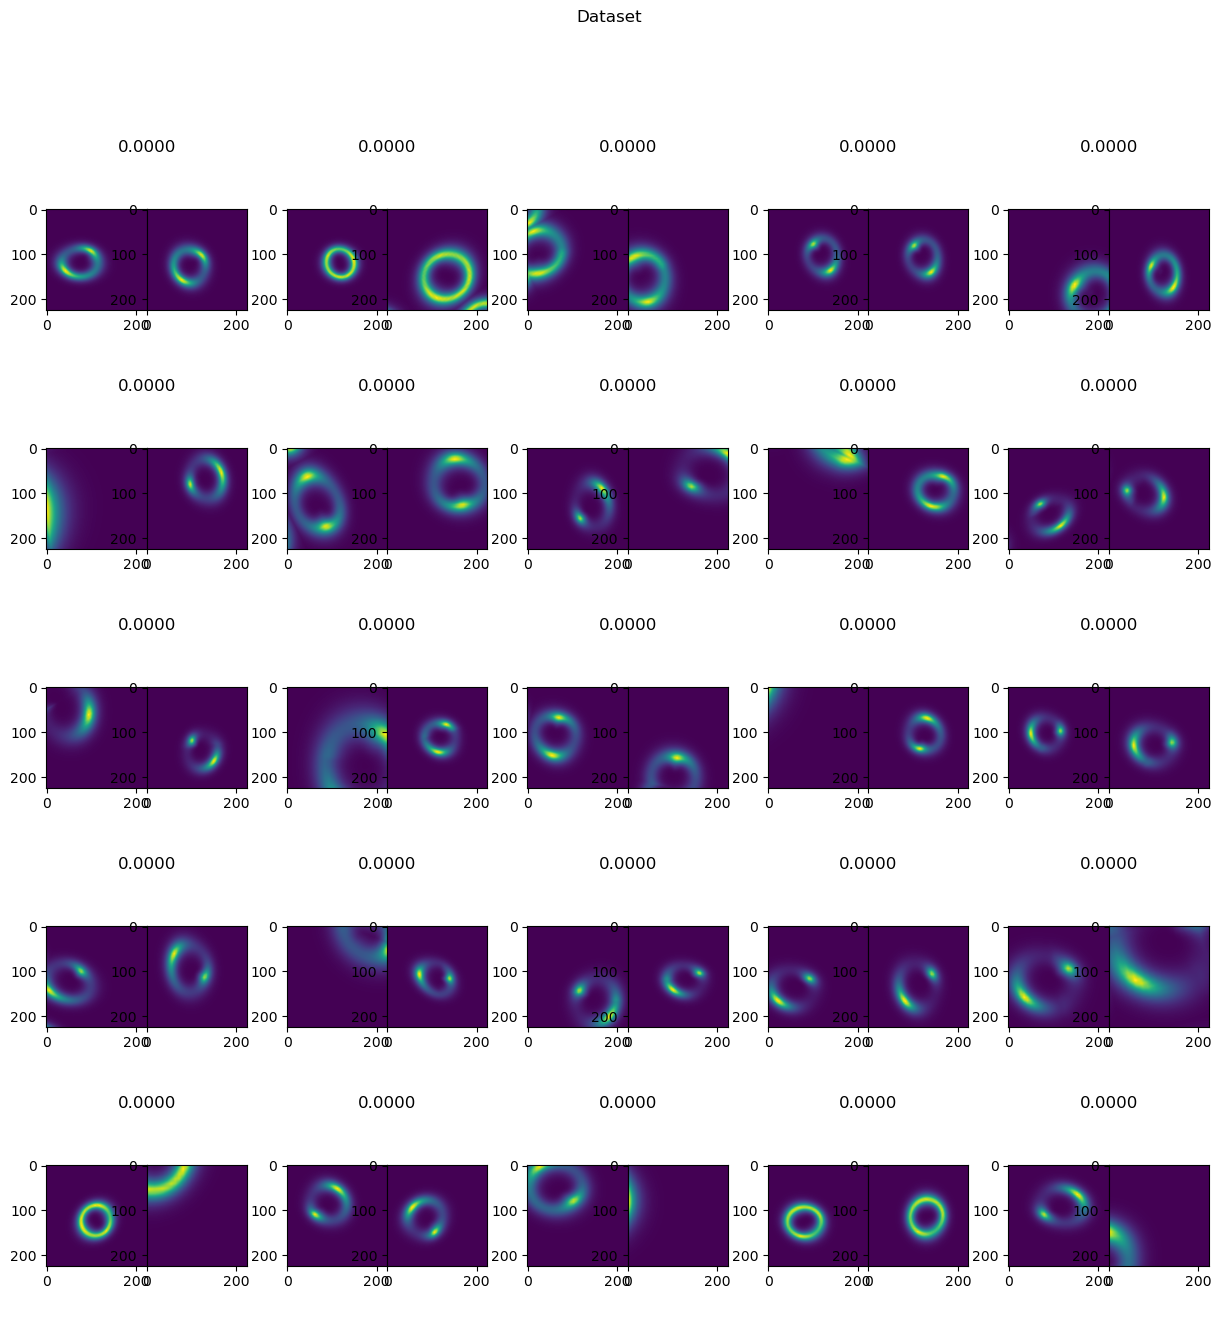

In [8]:
from utils.dataset import visualize_samples_ssl, DeepLenseDatasetSSL, DeepLenseDatasetSSLRegression

# trainset
dino_transform = DINOTransform()
train_transforms = dino_transform.get_transforms()
train_dataset = DeepLenseDatasetSSLRegression(destination_dir = dataset_dir, transforms = train_transforms, mode="train", dataset_name=dataset_name, download=True, channels=1, classes=classes)
logging.debug(f"train data: {len(train_dataset)}")
visualize_samples_ssl(train_dataset, labels_map=classes, num_rows_inner=1, num_cols_inner=2, regression=True)

In [9]:
# split in train and valid set
split_ratio = 0.25  # 0.25
valid_len = int(split_ratio * len(train_dataset))
train_len = len(train_dataset) - valid_len

train_dataset, val_set = random_split(train_dataset, [train_len, valid_len])

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

val_loader = DataLoader(
    dataset=val_set, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

# Load test dataset
# testset = default_dataset_setup.get_dataset(mode="val")
# test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=True)

# size check
sample = next(iter(train_loader))
logging.debug("num of classes: ", num_classes)
logging.debug(sample[0].shape)

--- Logging error ---
Traceback (most recent call last):
  File "/global/common/software/nersc/pm-2022q4/sw/pytorch/1.13.1/lib/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/global/common/software/nersc/pm-2022q4/sw/pytorch/1.13.1/lib/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/global/common/software/nersc/pm-2022q4/sw/pytorch/1.13.1/lib/python3.9/logging/__init__.py", line 663, in format
    record.message = record.getMessage()
  File "/global/common/software/nersc/pm-2022q4/sw/pytorch/1.13.1/lib/python3.9/logging/__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/global/common/software/nersc/pm-2022q4/sw/pytorch/1.13.1/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/global/common/software/nersc/pm-2022q4/sw/pytorch/1.13.1/lib/python3.

In [10]:
from lightly.loss import DINOLoss
from lightly.models.modules import DINOProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.dino_transform import DINOTransform
from lightly.utils.scheduler import cosine_schedule

In [11]:
class DINO(torch.nn.Module):
    def __init__(self, backbone, input_dim):
        super().__init__()

        self.backbone = backbone
        self.backbone[0] = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )

        self.student_backbone = self.backbone
        self.student_head = DINOProjectionHead(
            input_dim, 512, 64, 2048, freeze_last_layer=1
        )
        self.teacher_backbone = copy.deepcopy(self.backbone)
        self.teacher_head = DINOProjectionHead(input_dim, 512, 64, 2048)
        deactivate_requires_grad(self.teacher_backbone)
        deactivate_requires_grad(self.teacher_head)

    def forward(self, x):
        y = self.student_backbone(x).flatten(start_dim=1)
        z = self.student_head(y)
        return z

    def forward_teacher(self, x):
        y = self.teacher_backbone(x).flatten(start_dim=1)
        z = self.teacher_head(y)
        return z

In [12]:
class DINOTransformer(torch.nn.Module):
    def __init__(self, backbone, input_dim):
        super().__init__()

        self.backbone = backbone
        self.student_backbone = self.backbone
        self.student_head = DINOProjectionHead(
            input_dim, 512, 64, 512, freeze_last_layer=1
        )
        self.teacher_backbone = copy.deepcopy(self.backbone)
        self.teacher_head = DINOProjectionHead(input_dim, 512, 64, 512)
        deactivate_requires_grad(self.teacher_backbone)
        deactivate_requires_grad(self.teacher_head)

    def forward(self, x):
        y = self.student_backbone(x).flatten(start_dim=1)
        z = self.student_head(y)
        return z

    def forward_teacher(self, x):
        y = self.teacher_backbone(x).flatten(start_dim=1)
        z = self.teacher_head(y)
        return z

In [13]:
# # Create ResNet pretrain model
resnet = torchvision.models.resnet50()
backbone = nn.Sequential(*list(resnet.children())[:-1])

num_ftrs_dict = {
    "resnet18": 512,
    "resnet34": 512,
    "resnet50": 2048,

}

model =  DINO(backbone, input_dim=num_ftrs_dict[network_type])
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

summary(model, input_size=(2, 1, 224, 224), device="cuda")

Layer (type:depth-idx)                        Output Shape              Param #
DINO                                          [2, 2048]                 24,979,456
├─Sequential: 1-1                             [2, 2048, 1, 1]           --
│    └─Conv2d: 2-1                            [2, 64, 112, 112]         3,136
│    └─BatchNorm2d: 2-2                       [2, 64, 112, 112]         128
│    └─ReLU: 2-3                              [2, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [2, 64, 56, 56]           --
│    └─Sequential: 2-5                        [2, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [2, 256, 56, 56]          75,008
│    │    └─Bottleneck: 3-2                   [2, 256, 56, 56]          70,400
│    │    └─Bottleneck: 3-3                   [2, 256, 56, 56]          70,400
│    └─Sequential: 2-6                        [2, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [2, 512, 28, 28]         

In [14]:
network_config = {
    "s1_emb_dim": 64,  # stage 1 - dimension
    "s1_emb_kernel": 7,  # stage 1 - conv kernel size
    "s1_emb_stride": 4,  # stage 1 - conv stride
    "s1_proj_kernel": 3,  # stage 1 - attention ds-conv kernel size
    "s1_kv_proj_stride": 2,  # stage 1 - attention key / value projection stride
    "s1_heads": 2,  # stage 1 - heads
    "s1_depth": 2,  # stage 1 - depth
    "s1_mlp_mult": 3,  # stage 1 - feedforward expansion factor
    "s2_emb_dim": 128,  # stage 2 - (same as above)
    "s2_emb_kernel": 3,
    "s2_emb_stride": 2,
    "s2_proj_kernel": 3,
    "s2_kv_proj_stride": 2,
    "s2_heads": 2,
    "s2_depth": 2,
    "s2_mlp_mult": 3,
    "mlp_last": 256,
    "dropout": 0.1,
}

In [15]:
# in_features = 128
# # Transformer model
# backbone = TransformerModels(
#     transformer_type=train_config["network_type"],
#     num_channels=train_config["channels"],
#     num_classes=in_features,
#     img_size=image_size,
#     **network_config, # **train_config["network_config"]
# )


# model = DINOTransformer(backbone, input_dim=in_features)
# summary(model, input_size=(2, 1, 224, 224), device="cuda")

In [16]:
# optimizer
lr = optimizer_config["lr"]
weight_decay = optimizer_config["weight_decay"]
warmup_epochs = optimizer_config["warmup_epoch"]


optimizer_pretrain = optim.AdamW(model.parameters(), lr=lr, weight_decay = weight_decay)
warmup_epochs = warmup_epochs
num_train_steps = math.ceil(len(train_loader))
num_warmup_steps= num_train_steps * warmup_epochs
num_training_steps=int(num_train_steps * epochs_pretrain)

#learning rate scheduler
cosine_scheduler = get_cosine_schedule_with_warmup(optimizer_pretrain,num_warmup_steps = num_warmup_steps,num_training_steps =num_training_steps) 

In [17]:
criterion_pretrain = DINOLoss(
    output_dim=2048,
    warmup_teacher_temp_epochs=5,
)
# move loss to correct device because it also contains parameters
criterion_pretrain = criterion_pretrain.to(device)

In [18]:
import logging

In [ ]:
print("Starting Training")
for epoch in range(epochs_pretrain):
    total_loss = 0
    best_loss = float("inf")

    momentum_val = cosine_schedule(epoch, epochs_pretrain, 0.996, 1)
    for batch_idx, batch in enumerate(train_loader):
        views = batch[:3]
        
        update_momentum(model.student_backbone, model.teacher_backbone, m=momentum_val)
        update_momentum(model.student_head, model.teacher_head, m=momentum_val)
        views = [view.to(device) for view in views]
        global_views = views[:2]
        teacher_out = [model.forward_teacher(view) for view in global_views]
        student_out = [model.forward(view) for view in views]
        loss = criterion_pretrain(teacher_out, student_out, epoch=epoch)
        total_loss += loss.detach()
        loss.backward()

        # We only cancel gradients of student head.
        model.student_head.cancel_last_layer_gradients(current_epoch=epoch)
        optimizer_pretrain.step()
        cosine_scheduler.step()
        optimizer_pretrain.zero_grad()        
        if ci:
            break    
            
        if batch_idx % 100 == 0:
            logging.debug(
                f"Epoch [{epoch}/{epochs_pretrain}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item()}"
            )

    if ci:
        break    
    
    if total_loss < best_loss:
        best_loss = total_loss

        torch.save(model.state_dict(), model_path_pretrained)

    avg_loss = total_loss / len(train_loader)
    
    logging.debug(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

In [19]:
class FinetuneClassifier(nn.Module):
    def __init__(self, backbone, head):
        super(FinetuneClassifier, self).__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        z = self.backbone[0](x).flatten(start_dim=1)
        z = self.backbone[1](z)
        z = self.head(z)
        return z

In [20]:
# load pretrained model
path = "/global/u1/s/sachdevk/DeepLense/Transformers_Classification_DeepLense_Kartik_Sachdev/logger/2023-09-21-18-35-26_Regression_DINO_resnet50_Model_II/checkpoint/resnet50_pretrained_Model_II_2023-09-21-18-35-26.pt"
model.load_state_dict(torch.load(os.path.join(path)))
model.to(device=device)


DINO(
  (backbone): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 25

In [21]:
backbone = model.student_backbone # nn.Sequential(*list(model.backbone.children())[:-1])
backbone = nn.Sequential(model.student_backbone, model.student_head)

In [22]:
classification_head = nn.Sequential(
    nn.Linear(2048, 2048),
    # nn.ReLU(),
    nn.Linear(2048, num_classes),)
model = FinetuneClassifier(backbone, classification_head)


In [23]:
!pwd

/global/u1/s/sachdevk/DeepLense/Transformers_Classification_DeepLense_Kartik_Sachdev


In [24]:
# PATH = "/global/u1/s/sachdevk/DeepLense/Transformers_Classification_DeepLense_Kartik_Sachdev/logger/2023-09-21-18-35-26_Regression_DINO_resnet50_Model_II/checkpoint/resnet50_finetune_Model_II_2023-09-21-18-35-26.pt"
# model.load_state_dict(torch.load(PATH))
model.to(device)
summary(model, input_size=(2, 1, 224, 224), device="cuda")

Layer (type:depth-idx)                             Output Shape              Param #
FinetuneClassifier                                 [2, 1]                    --
├─Sequential: 1-1                                  --                        --
│    └─Sequential: 2-1                             [2, 2048, 1, 1]           --
│    │    └─Conv2d: 3-1                            [2, 64, 112, 112]         3,136
│    │    └─BatchNorm2d: 3-2                       [2, 64, 112, 112]         128
│    │    └─ReLU: 3-3                              [2, 64, 112, 112]         --
│    │    └─MaxPool2d: 3-4                         [2, 64, 56, 56]           --
│    │    └─Sequential: 3-5                        [2, 256, 56, 56]          215,808
│    │    └─Sequential: 3-6                        [2, 512, 28, 28]          1,219,584
│    │    └─Sequential: 3-7                        [2, 1024, 14, 14]         7,098,368
│    │    └─Sequential: 3-8                        [2, 2048, 7, 7]           14,964,736
│   

In [25]:
import math
learning_rate = 1e-4 # 3e-4
weight_decay =  0.01

#optimizer
optimizer_finetune = optim.AdamW(model.parameters(), lr=learning_rate) #  weight_decay = 1e-4
warmup_epochs = 3
num_train_steps = math.ceil(len(train_loader))
num_warmup_steps= num_train_steps * warmup_epochs
num_training_steps=int(num_train_steps * epochs_finetune)

#learning rate scheduler
cosine_scheduler = get_cosine_schedule_with_warmup(optimizer_finetune,num_warmup_steps = num_warmup_steps,num_training_steps =num_training_steps) 

In [26]:
criterion_finetune = nn.MSELoss()
import torch.nn.functional as F

scale_target = 1e22
class DeepLenseLoss(nn.MSELoss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super().__init__(size_average, reduce, reduction)

    def forward(self, input: torch.Tensor, target: torch.Tensor, scale_target: float = 1e22, scale_output: float=1.0) -> torch.Tensor:
        input = input.flatten()
        input = scale_output * input
        target = scale_target * target
        mse_loss = F.mse_loss(input, target, reduction=self.reduction) 
        return  mse_loss

criterion_finetune = DeepLenseLoss()


In [27]:
arr = torch.randn(256, 1)
arr.flatten().shape

torch.Size([256])

In [28]:
# Finetune
finetune_regression(
    epochs_finetune,
    model,
    device,
    train_loader,
    criterion_finetune,
    optimizer_finetune,
    finetuned_model_path,
    valid_loader=val_loader,
    ci=ci,
    scheduler=cosine_scheduler,
)
#     

DEBUG:root:Epoch [0/20], Batch [0/88], Loss: 0.09974153339862823
DEBUG:root:====== Eval started ======
DEBUG:root:====== Model saved ======
DEBUG:root:Epoch : 1 - loss : 0.0757654681801796 - val_loss : 0.06113484501838684 

DEBUG:root:Epoch [1/20], Batch [0/88], Loss: 0.05355673283338547
DEBUG:root:====== Eval started ======
DEBUG:root:Epoch : 2 - loss : 0.06399533152580261 - val_loss : 0.06214699149131775 

DEBUG:root:Epoch [2/20], Batch [0/88], Loss: 0.06374530494213104
DEBUG:root:====== Eval started ======
DEBUG:root:Epoch : 3 - loss : 0.06481468677520752 - val_loss : 0.060819029808044434 

DEBUG:root:Epoch [3/20], Batch [0/88], Loss: 0.07324490696191788
DEBUG:root:====== Eval started ======
DEBUG:root:Epoch : 4 - loss : 0.06245154142379761 - val_loss : 0.0594637356698513 

DEBUG:root:Epoch [4/20], Batch [0/88], Loss: 0.06336129456758499
DEBUG:root:====== Eval started ======
DEBUG:root:====== Model saved ======
DEBUG:root:Epoch : 5 - loss : 0.05316154286265373 - val_loss : 0.0503374

In [29]:
test_dataset_dir = dataset_dir
test_dataset = DeepLenseDatasetSSLRegression(destination_dir = test_dataset_dir, transforms = train_transforms, mode="test", dataset_name=dataset_name, download=True, channels=1, classes=classes)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

Model_II dataset already exists


In [30]:
# load pretrained model
# path = "/global/u1/s/sachdevk/DeepLense/Transformers_Classification_DeepLense_Kartik_Sachdev/logger/2023-09-21-18-35-26_Regression_DINO_resnet50_Model_II/checkpoint/resnet50_finetune_Model_II_2023-09-21-18-35-26.pt"
# model.load_state_dict(torch.load(os.path.join(path)))
# model.to(device=device)


In [31]:
# TODO: combine all classes
class InferenceRegressionSSL(InferenceABC):
    def __init__(
        self,
        best_model: nn.Module,
        test_loader: DataLoader,
        device: str,
        num_classes: int,
        testset: Dataset,
        dataset_name: str,
        labels_map: dict,
        image_size: int,
        channels: int,
        log_dir: str,
        criterion,
        destination_dir="data",
        current_time=None,
        scale_output=1,
        scale_target=1,
        
    ) -> None:
        self.criterion = criterion
        self.scale_output = scale_output
        self.scale_target = scale_target
        
        super().__init__(
            best_model,
            test_loader,
            device,
            num_classes,
            testset,
            dataset_name,
            labels_map,
            image_size,
            channels,
            log_dir,
            destination_dir,
            current_time,
        )

        """Class for infering the trained model. \n
        Plots `Confusion matrix`, computes `AUC` and `ROC` score.  `normalize=True`

        Args:
            best_model (nn.Module): best trained model to infer
            test_loader (DataLoader): pytorch loader for testset
            device (Union[int, str]): number or name of device
            num_classes (int): # of classes for classification
            testset (Dataset): dataset for testing
            dataset_name (str): name of testeset
            labels_map (dict): dict for mapping labels to number e.g `{0: "axion"}`
            image_size (int): size of input image
            channels (int): # of channels of input image
            log_dir (str): directory for saving logs
            destination_dir (str, optional): directory where data is saved. Defaults to "data".

        Example:
        >>>     infer_obj = Inference(
        >>>             best_model= model,
        >>>             test_loader= test_loader,
        >>>             device=device,
        >>>             num_classes=num_classes,
        >>>             testset=testset,
        >>>             dataset_name=dataset_name,
        >>>             labels_map=classes,
        >>>             image_size=image_size,
        >>>             channels=train_config["channels"],
        >>>             destination_dir="data",
        >>>             log_dir=log_dir)
        """

    def infer(self):
        """Plots `ROC` curve"""
        print("Inference started ...")
        total = 0
        all_test_loss = []
        all_test_accuracy = []
        self.label_true_arr = []
        self.label_true_arr_onehot = []
        self.label_pred_arr = []
        self.pred_arr = []
        self.epoch_loss = 0
        plt.rcParams.update(plt.rcParamsDefault)
        fig = plt.figure()

        correct = 0
        with torch.no_grad():
            self.best_model.eval()
            for batch_idx, batch in enumerate(self.test_loader):
                x = batch[0].to(self.device)
                label = batch[-1].to(self.device)
                output = self.best_model(x)
                loss = self.criterion(output, label)
                self.epoch_loss += loss

                self.label_pred_arr.append(output.cpu().numpy().flatten()*self.scale_output)
                self.label_true_arr.append(label.cpu().numpy()*self.scale_target)

                # total += t.shape[0]
                # correct += (prediction == t).sum().item()
            self.epoch_loss = self.epoch_loss / len(self.test_loader)
            
        self.label_pred_arr = np.concatenate(self.label_pred_arr, axis=0)
        self.label_true_arr = np.concatenate(self.label_true_arr, axis=0)

    def plot_scatter(self):
        print("MAE loss: ", self.epoch_loss)
        plt.scatter(self.label_true_arr, self.label_pred_arr, color="black")

        plt.title("Validation Set")
        plt.xlabel("Observed mass")
        plt.ylabel("Predicted mass")
        plt.show()

In [32]:
channels = 1
infer_obj = InferenceRegressionSSL(
    model,
    val_loader,
    device,
    num_classes,
    val_set,
    dataset_name,
    labels_map=classes, # classes
    image_size=image_size,
    channels=channels,
    destination_dir="data",
    log_dir=log_dir,  # log_dir
    criterion= criterion_finetune,
    scale_output=1/scale_target,
    scale_target=1,
)

In [33]:
infer_obj.infer()

Inference started ...


MAE loss:  tensor(0.0207, device='cuda:0')


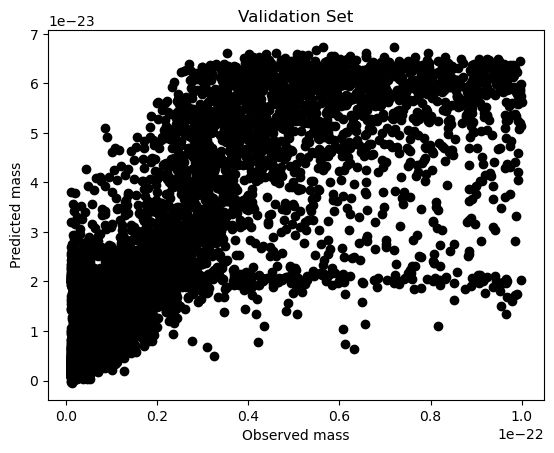

In [34]:
infer_obj.plot_scatter()

In [35]:
plt.plot(infer_obj.label_true_arr, infer_obj.label_pred_arr, "--")

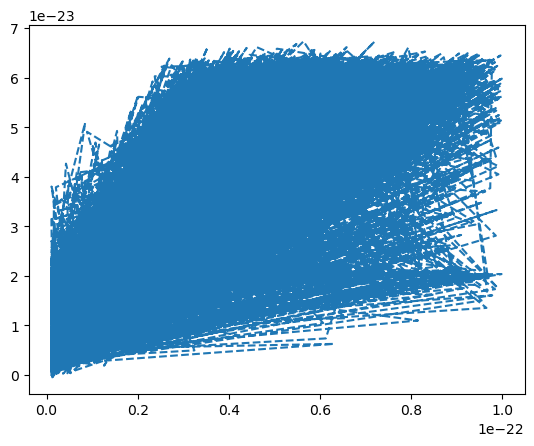

In [36]:
plt.show()

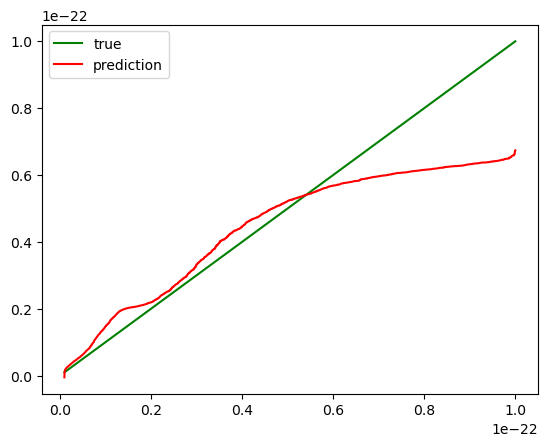

In [50]:
plt.plot(np.sort(infer_obj.label_true_arr), np.sort(infer_obj.label_true_arr), color="green", label="true")
plt.plot(np.sort(infer_obj.label_true_arr), np.sort(infer_obj.label_pred_arr), color="red", label="prediction")
plt.legend()
plt.show()

In [38]:
infer_obj.label_pred_arr

array([4.2625180e-24, 2.1190117e-23, 6.4678232e-24, ..., 2.0843177e-23,
       2.6885167e-24, 4.7032704e-23], dtype=float32)